# Identify gaps in CARE service relative to unsheltered population
* Map number of CARE/CARE+ requests by tract (2017-2019)
* Map number of homeless counts by tract (2017-2019)
* Map difference: (total CARE/CARE+ for homeless encampments) - (total homelessness)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import intake
import matplotlib.pyplot as plt
%matplotlib inline
import folium
import boto3

In [2]:
catalog = intake.open_catalog('../catalogs/*.yml')
bucket_name = 's3://city-of-los-angeles-data-lake/public-health-dashboard/'

s3 = boto3.client('s3')

## Import files

In [3]:
homeless = gpd.read_file(f'{bucket_name}gis/raw/homelessness_lacity_2017_2019.geojson')
# Only keep the tracts that are withn City of LA
homeless = homeless[homeless.CD != 0]

pop = pd.read_parquet(f'{bucket_name}data/raw/pop_by_tract2017.parquet') 

In [4]:
care = gpd.read_file(f'{bucket_name}gis/intermediate/care311_tracts.geojson')

In [5]:
tracts = gpd.read_file(f'{bucket_name}gis/raw/census_tracts.geojson')

## Merge dfs

In [45]:
# Merge homelessness and population
m1 = pd.merge(homeless, pop, on = 'GEOID', how = 'inner', validate = 'm:1')

In [46]:
# Merge in CARE 311 service requests
m2 = pd.merge(m1, care, on = ['GEOID', 'year'], how = 'left', validate = '1:1')

In [47]:
# Keep the geometry from homelessness because it's been clipped to City of LA
m2 = m2.drop(columns = ['geometry_y'])

m2.rename(columns = {'geometry_x': 'geometry'}, inplace = True)

In [59]:
# Fill in NaNs with zeroes for CARE service requests
for col in ['bulky', 'homeless', 'illegal', 'other']:
    m2[col] = m2[col].fillna(0)

In [64]:
pivot1 = m2.dissolve(by = ['GEOID', 'clipped_area', 'full_area', 
                           'CD', 'pop', 'SPA', 'SD'], aggfunc = 'sum').reset_index().drop(columns = ['year'])

In [65]:
pivot1.head()

GEOID  clipped_area  full_area  CD     pop  SPA  SD  \
0  06037101110      0.441019   0.441019   7  4566.0    2   5   
1  06037101122      1.020722   1.020722   7  3064.0    2   5   
2  06037101210      0.251197   0.251197   7  6043.0    2   5   
3  06037101220      0.269802   0.269802   7  3340.0    2   5   
4  06037101300      0.995075   0.996474   7  4285.0    2   5   

                                            geometry  totUnshelt  totShelt  \
0  POLYGON ((6470325.130 1916664.185, 6470741.805...      29.498         0   
1  POLYGON ((6470023.741 1922128.259, 6470036.243...       4.618         0   
2  POLYGON ((6471180.326 1915672.127, 6471643.245...      41.897         0   
3  POLYGON ((6475263.687 1914312.278, 6475265.823...      72.464         0   
4  POLYGON ((6477589.221 1913725.301, 6477590.206...      36.710         0   

   totPeople  bulky  homeless  illegal  other  
0     29.498    1.0       3.0      0.0    0.0  
1      4.618    0.0       0.0      0.0    0.0  
2     41.897    1.0       3.0      6.0    1.0  
3     72.464    2.0       1.0      1.0    0.0  
4     36.710    2.0       8.0      5.0    0.0

In [76]:
pivot1.totUnshelt.describe()

count     994.000000
mean       71.426540
std       162.045017
min         0.000000
25%        18.554500
50%        39.450000
75%        76.858750
max      3823.916000
Name: totUnshelt, dtype: float64

## Map homelessness

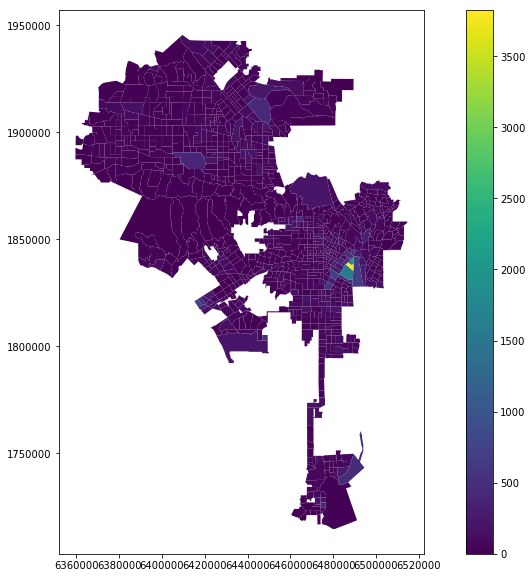

In [80]:
fig, ax = plt.subplots(figsize=(15, 10))
pivot1.plot(column='totUnshelt',ax=ax, legend=True)

In [78]:
unsheltered = pivot1[['GEOID', 'totUnshelt']]

#bins = list(unsheltered['totUnshelt'].quantile([0, 0.25, 0.5, 0.75, 1]))
bins = [0, 5, 50, 100, 4000]

m = folium.Map(
    location=[34.0536, -118.2427], 
    zoom_start=12, 
    tiles='cartodbpositron'
)


# Add the color for the chloropleth:
folium.Choropleth(
    geo_data = pivot1[['GEOID', 'geometry']],
    name = 'choropleth',
    data = unsheltered,
    columns = ['GEOID', 'totUnshelt'],
    key_on = 'feature.properties.GEOID',
    fill_color = 'BuPu',
    fill_opacity = 0.95,
    line_opacity = 0.8, line_color='white',
    bins = bins,
    legend_name = 'Total Unsheltered Population'
).add_to(m)

#folium.LayerControl().add_to(m)
 
m


In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))
gdf2.plot(column='totUnshelt', ax=ax, legend=True)